In [1]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from pyhessian import hessian
import numpy as np

from pytorchcv.model_provider import get_model as ptcv_get_model # model

import sys, os

import easydict

import torch
import torch.nn as nn
import numpy as np

import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder

from few_shot_learning_system import MAMLFewShotClassifier
from utils import loss_landscape
from utils import gradcam

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" # https://mtl.yyliu.net/download/Lmzjm9tX.html
# os.environ['TEST_DATASET'] = "CIFAR_FS" # https://drive.google.com/file/d/1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI/view
#os.environ['TEST_DATASET'] = "CUB" # https://data.caltech.edu/records/65de6-vp158

In [4]:
args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML+Arbiter_5way_5shot",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 150,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":128,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": True,
  "use_bias": True,
  "smoothing": False,
  "knowledge_distillation": False,
  "momentum": "SGD"
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

In [5]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)

Using max pooling
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params


C:\Users\JM\anaconda3\envs\metal\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Inner Loop parameters
Outer Loop parameters
log_dir ===  C:\Users\JM\PycharmProjects\MAML\MAML+Arbiter_5way_5shot
attempting to find existing checkpoint
dataset_splits ==  dict_keys(['test', 'train', 'val'])
data {'test': 12000, 'train': 38400, 'val': 9600}
train_seed 985773, val_seed: 985773, at start time
50000 75000


In [6]:
maml_system.state

{'best_val_acc': 0.6818444436788559,
 'best_val_iter': 48000,
 'current_iter': 50000,
 'best_epoch': 96,
 'train_loss_mean': 0.4526471059322357,
 'train_loss_std': 0.12993412983496969,
 'train_accuracy_mean': 0.8343333342075347,
 'train_accuracy_std': 0.0548158550248203,
 'train_loss_importance_vector_0_mean': 0.006000000052154064,
 'train_loss_importance_vector_0_std': 0.0,
 'train_loss_importance_vector_1_mean': 0.006000000052154064,
 'train_loss_importance_vector_1_std': 0.0,
 'train_loss_importance_vector_2_mean': 0.006000000052154064,
 'train_loss_importance_vector_2_std': 0.0,
 'train_loss_importance_vector_3_mean': 0.006000000052154064,
 'train_loss_importance_vector_3_std': 0.0,
 'train_loss_importance_vector_4_mean': 0.9760000109672546,
 'train_loss_importance_vector_4_std': 0.0,
 'train_learning_rate_mean': 0.00010000000000000003,
 'train_learning_rate_std': 2.710505431213761e-20,
 'val_loss_mean': 0.8508474173148474,
 'val_loss_std': 0.14179470314582376,
 'val_accuracy_mean'

# 1. 학습된 모델을 불러온다

In [7]:
model_save_dir = maml_system.saved_models_filepath
model_name = "train_model"
model_idx = maml_system.state['best_epoch']

state = maml_system.model.load_model(model_save_dir=model_save_dir,
                                     model_name=model_name,
                                     model_idx=model_idx+1)

state_dict_loaded = state['network']

maml_system.model.load_state_dict(state_dict=state_dict_loaded)

# # 잘 불러왔는지 확인하는 코드
# print("state_dict_loaded == ",state_dict_loaded)
# print("="*10)
# for key, value in maml_system.model.named_parameters():
#     print(key)
#     print(value)
maml_system.model

MAMLFewShotClassifier(
  (classifier): VGGReLUNormNetwork(
    (layer_dict): ModuleDict(
      (conv0): MetaConvNormLayerReLU(
        (layer_dict): ModuleDict()
        (conv): MetaConv2dLayer()
        (norm_layer): MetaBatchNormLayer(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): MetaConvNormLayerReLU(
        (layer_dict): ModuleDict()
        (conv): MetaConv2dLayer()
        (norm_layer): MetaBatchNormLayer(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): MetaConvNormLayerReLU(
        (layer_dict): ModuleDict()
        (conv): MetaConv2dLayer()
        (norm_layer): MetaBatchNormLayer(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv3): MetaConvNormLayerReLU(
        (layer_dict): ModuleDict()
        (conv): MetaConv2dLayer()
        (norm_layer): MetaBatchNormLayer(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (line

# Grad-CAM 구현
## 추후 jupyter notebook이 아닌 python 파일로 이동

In [8]:
def visualize_grad_cam(input_image, grad_cam):
    """
    Grad-CAM을 시각화하는 함수.
    input_image: 원본 이미지 (numpy 배열, shape: (H, W, C))
    grad_cam: Grad-CAM 결과 (numpy 배열, shape: (H, W))
    """
    # Grad-CAM 결과를 [0, 1] 범위로 정규화
    # grad_cam = (grad_cam - np.min(grad_cam)) / (np.max(grad_cam) - np.min(grad_cam))
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
    
    img = individual_images[i].cpu().squeeze()
    

    # 원본 이미지를 (H, W, C)로 변환
    input_image = individual_images[i].cpu().squeeze()
    input_image = input_image.permute(1, 2, 0) # (channels, height, width) -> (height, width, channels)
    input_image = input_image * torch.tensor([1 / 255.0, 1 / 255.0, 1 / 255.0]) + torch.tensor([104 / 255.0, 117 / 255.0, 128 / 255.0]) # Normalize의 반대로 [0, 1] 범위로 복원
    input_image = torch.clamp(input_image, 0, 1)  # 클리핑을 통해 값을 [0, 1]로 제한

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(input_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(input_image, alpha=0.5)
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.axis("off")

    plt.show()

C:\Users\JM\PycharmProjects\MAML\meta_neural_network_architectures.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  if param.grad is not None:


1 128 10 10
torch.Size([1, 3, 84, 84])


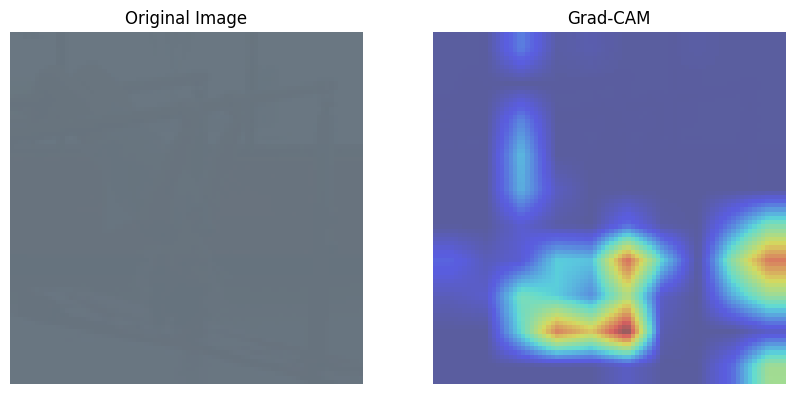

1 128 10 10
torch.Size([1, 3, 84, 84])


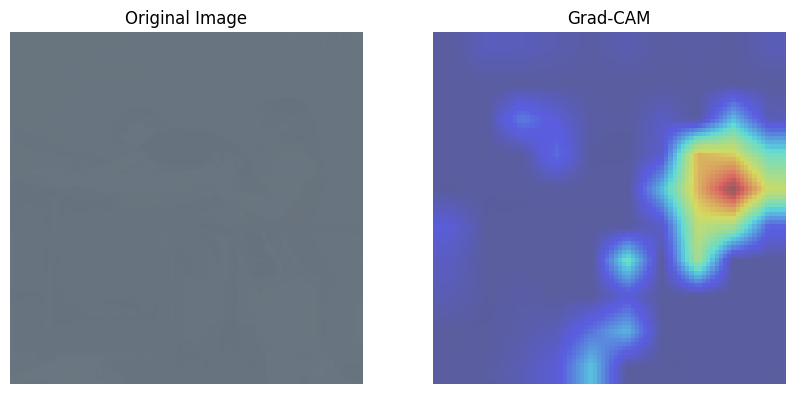

1 128 10 10
torch.Size([1, 3, 84, 84])


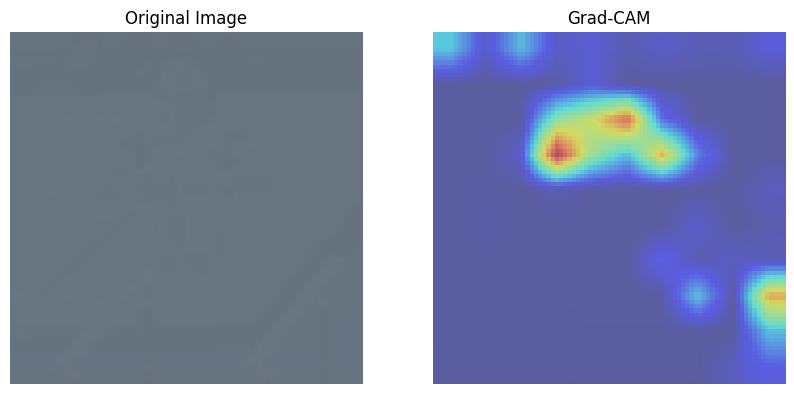

1 128 10 10
torch.Size([1, 3, 84, 84])


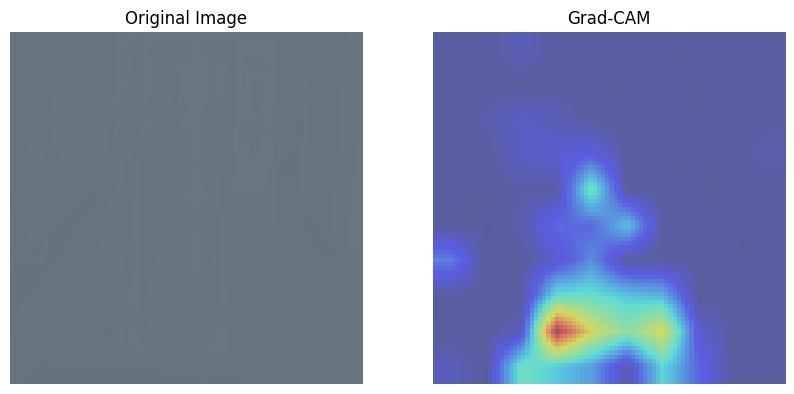

1 128 10 10
torch.Size([1, 3, 84, 84])


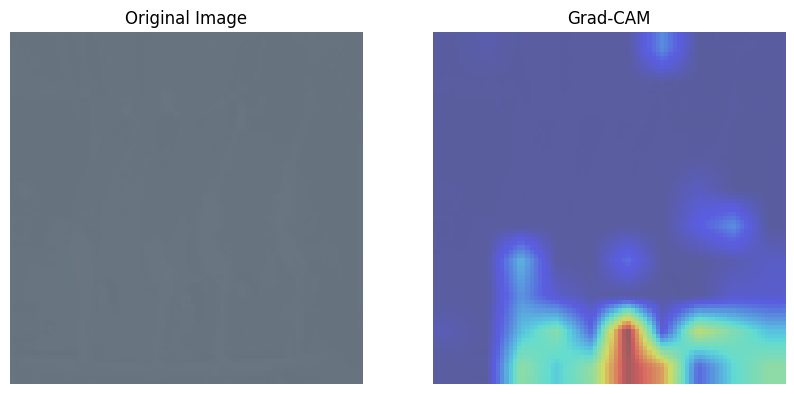

1 128 10 10
torch.Size([1, 3, 84, 84])


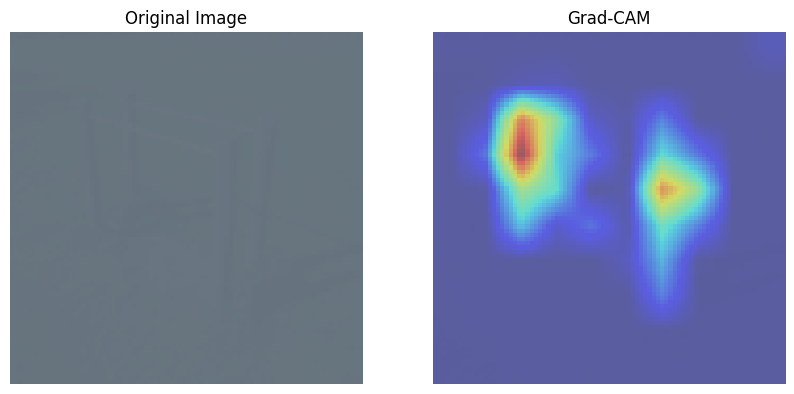

1 128 10 10
torch.Size([1, 3, 84, 84])


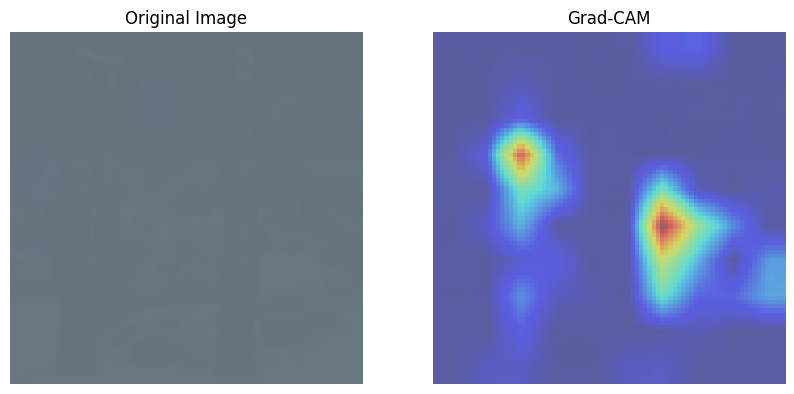

1 128 10 10
torch.Size([1, 3, 84, 84])


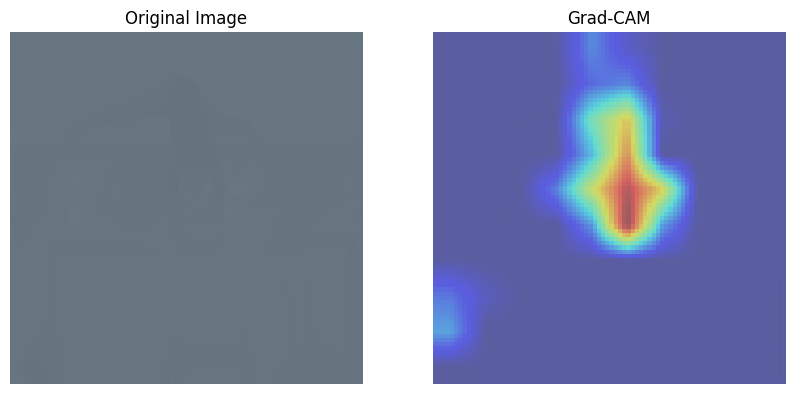

1 128 10 10
torch.Size([1, 3, 84, 84])


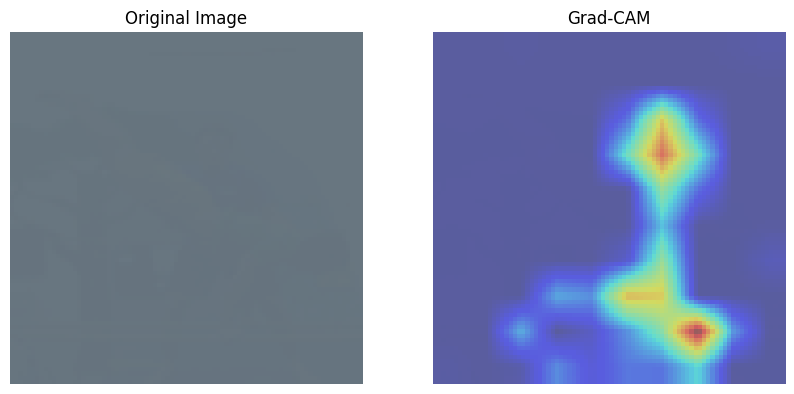

1 128 10 10
torch.Size([1, 3, 84, 84])


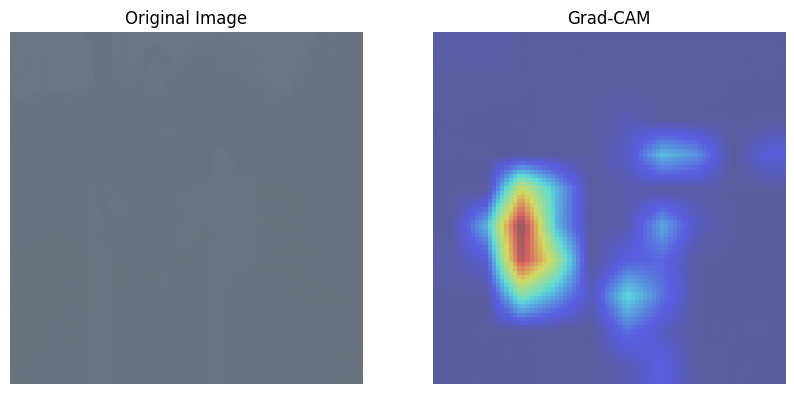

1 128 10 10
torch.Size([1, 3, 84, 84])


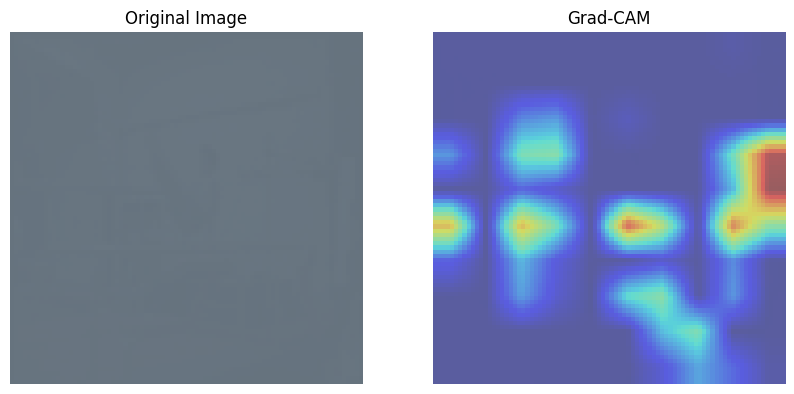

1 128 10 10
torch.Size([1, 3, 84, 84])


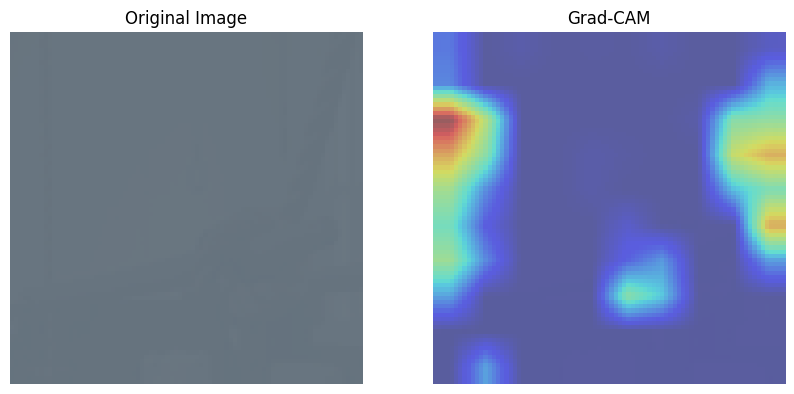

1 128 10 10
torch.Size([1, 3, 84, 84])


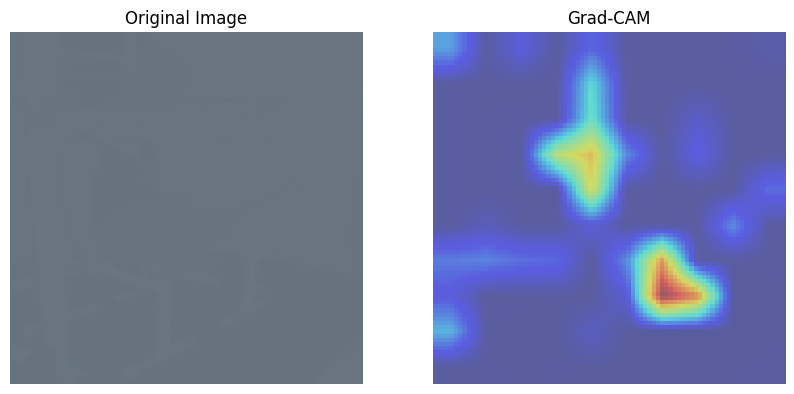

1 128 10 10
torch.Size([1, 3, 84, 84])


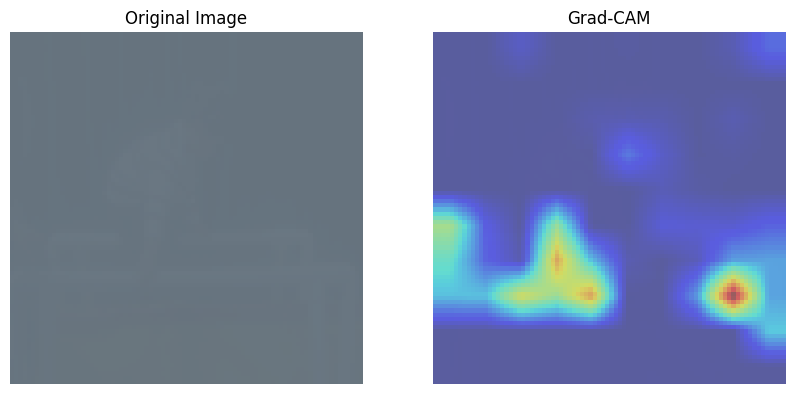

1 128 10 10
torch.Size([1, 3, 84, 84])


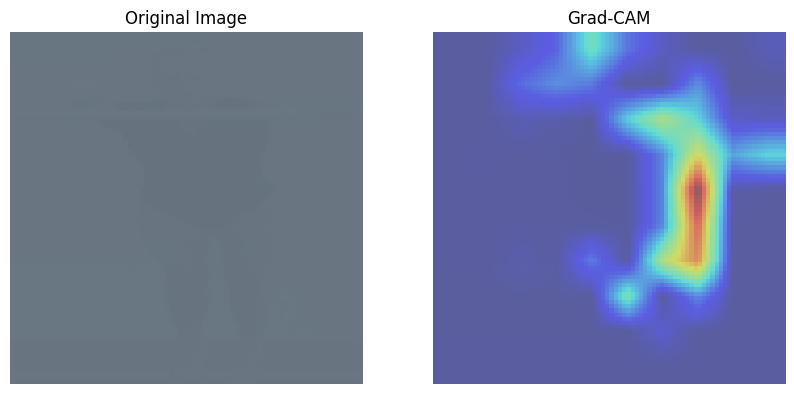

1 128 10 10
torch.Size([1, 3, 84, 84])


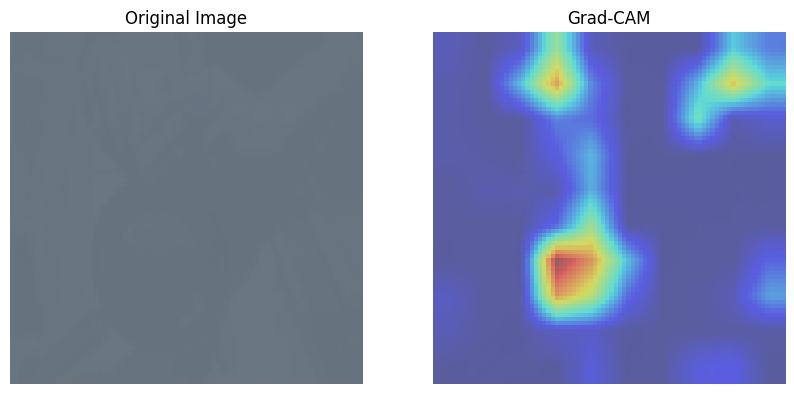

1 128 10 10
torch.Size([1, 3, 84, 84])


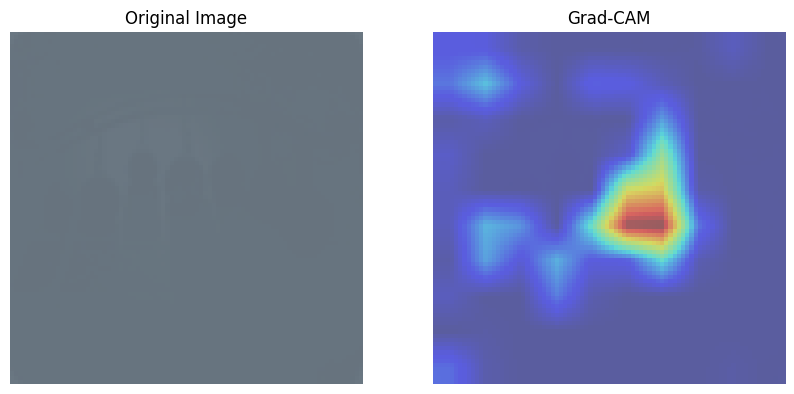

1 128 10 10
torch.Size([1, 3, 84, 84])


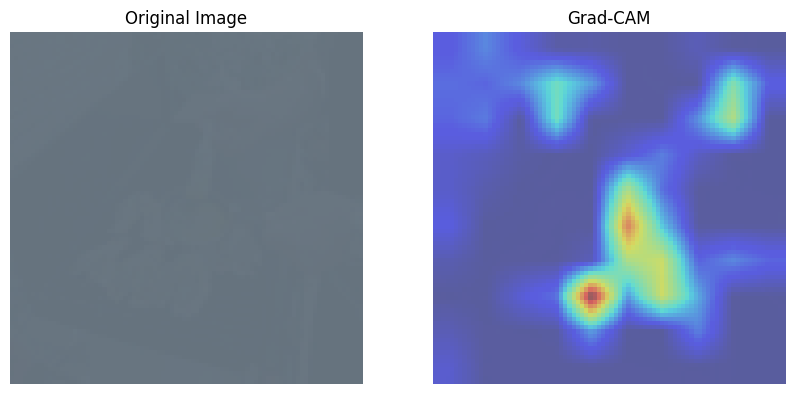

1 128 10 10
torch.Size([1, 3, 84, 84])


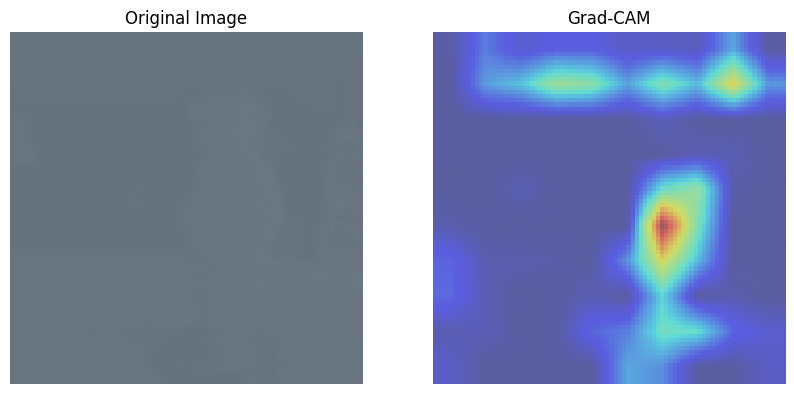

1 128 10 10
torch.Size([1, 3, 84, 84])


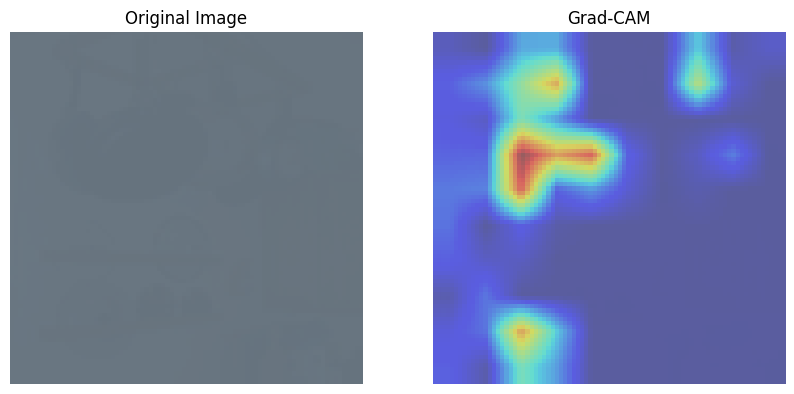

1 128 10 10
torch.Size([1, 3, 84, 84])


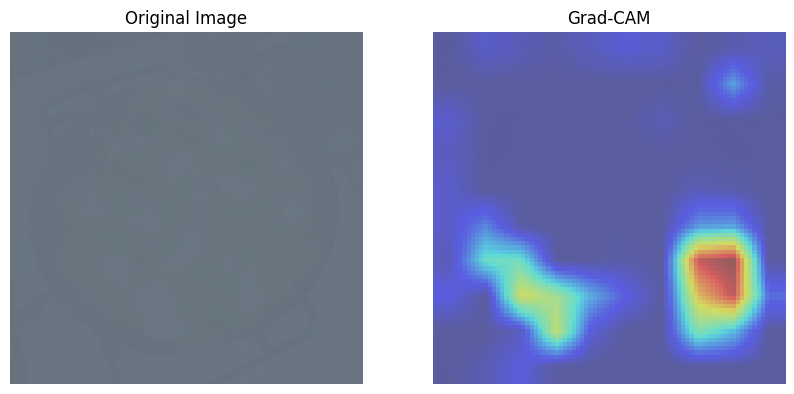

1 128 10 10
torch.Size([1, 3, 84, 84])


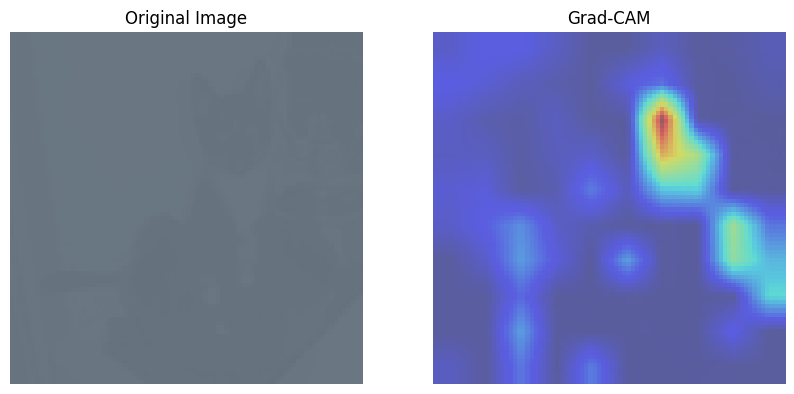

1 128 10 10
torch.Size([1, 3, 84, 84])


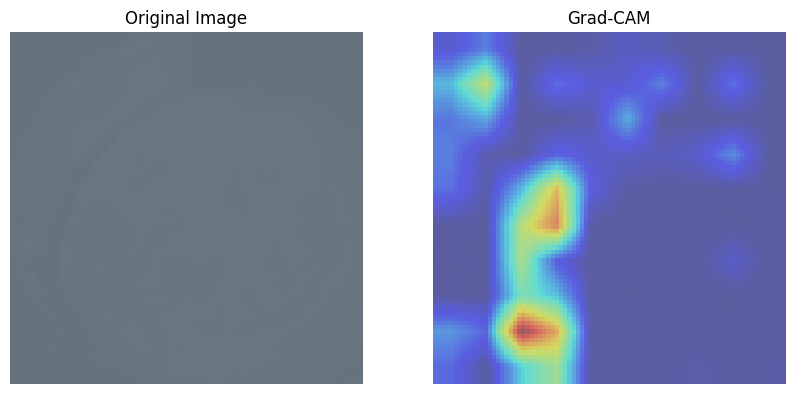

1 128 10 10
torch.Size([1, 3, 84, 84])


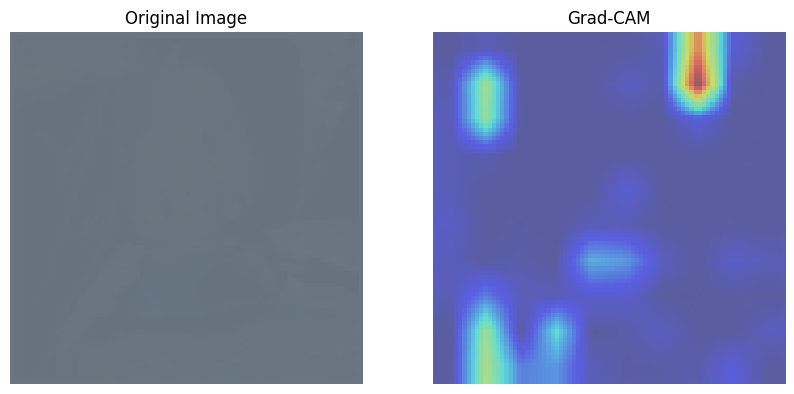

1 128 10 10
torch.Size([1, 3, 84, 84])


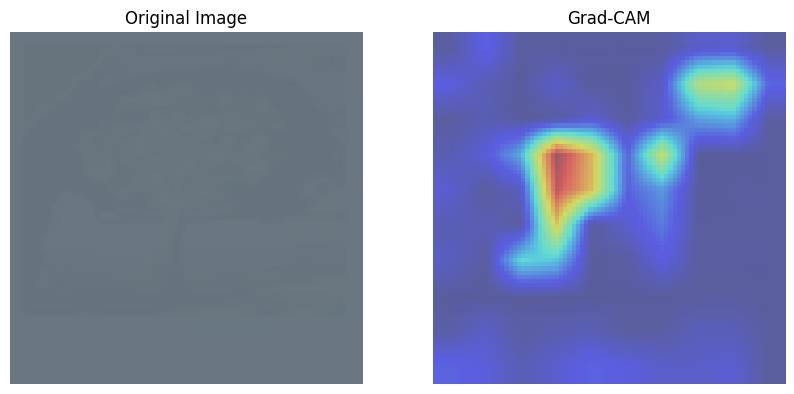

1 128 10 10
torch.Size([1, 3, 84, 84])


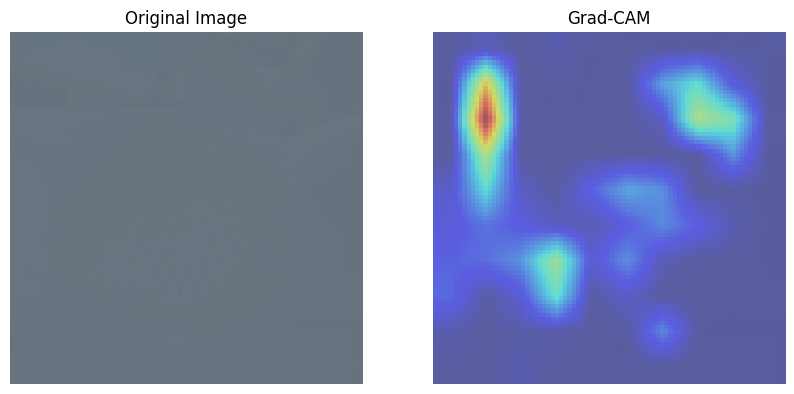

1 128 10 10
torch.Size([1, 3, 84, 84])


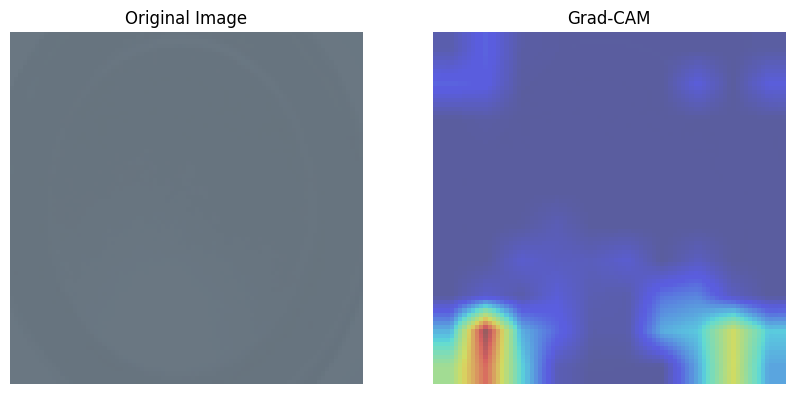

1 128 10 10
torch.Size([1, 3, 84, 84])


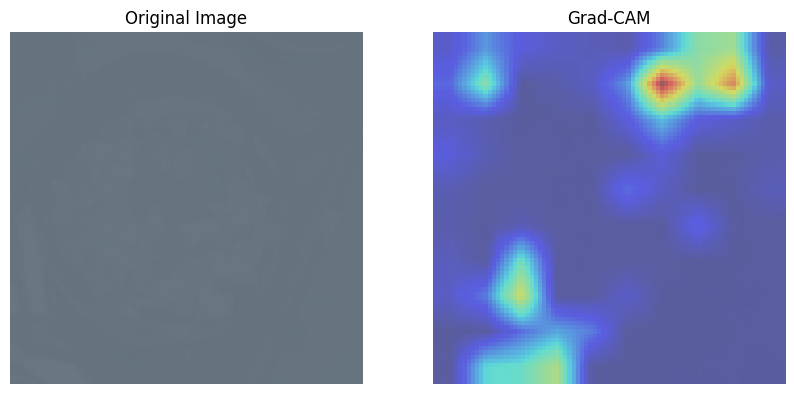

1 128 10 10
torch.Size([1, 3, 84, 84])


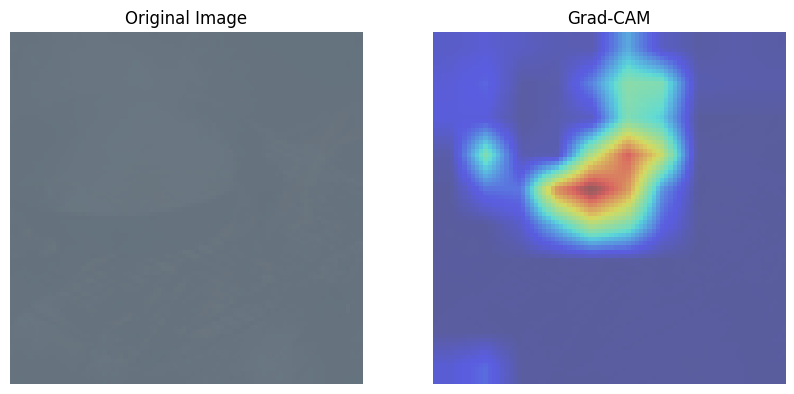

1 128 10 10
torch.Size([1, 3, 84, 84])


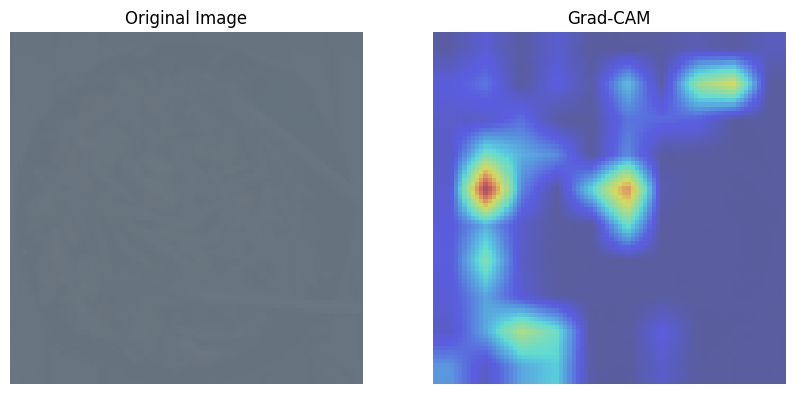

1 128 10 10
torch.Size([1, 3, 84, 84])


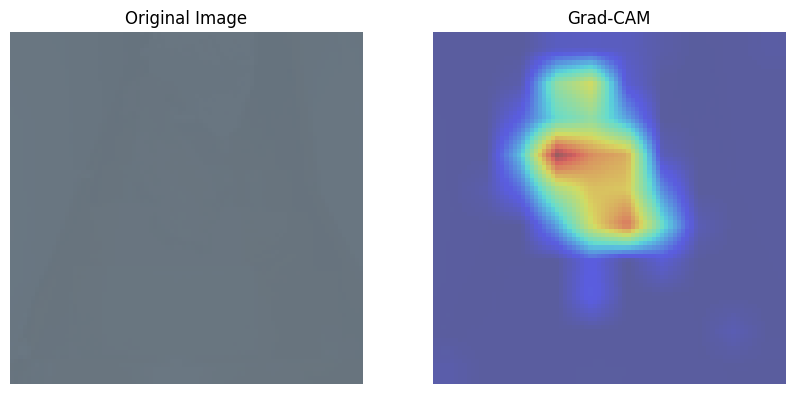

1 128 10 10
torch.Size([1, 3, 84, 84])


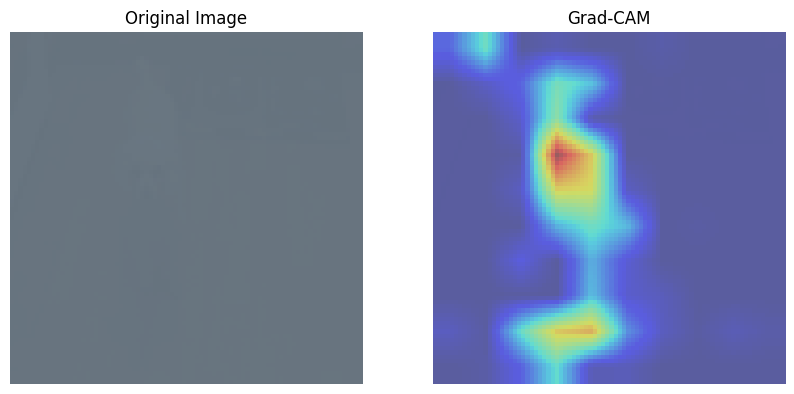

1 128 10 10
torch.Size([1, 3, 84, 84])


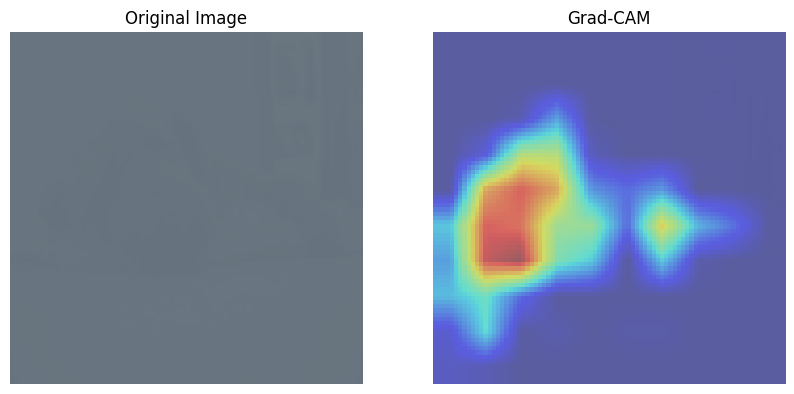

1 128 10 10
torch.Size([1, 3, 84, 84])


KeyboardInterrupt: 

In [9]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/2), augment_images=False)

figure_idx = 0

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())
        
        
        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
            name.replace('module.', ''): value.unsqueeze(0).repeat(
                [num_devices] + [1 for i in range(len(value.shape))]) for
            name, value in names_weights_copy.items()}
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
        num_steps=5
        for num_step in range(num_steps):            
            support_loss, support_preds, support_loss_seperate, fetaure_map = maml_system.model.net_forward(
                    x=x_support_set_task,
                    y=y_support_set_task,
                    weights=names_weights_copy,
                    backup_running_statistics=num_step == 0,
                    training=True,
                    num_step=num_step,
                    training_phase='test',
                    epoch=0
                )
        
            generated_alpha_params = {}

            if maml_system.model.args.arbiter:
                support_loss_grad = torch.autograd.grad(support_loss, names_weights_copy.values(),
                                                        retain_graph=True)

                names_grads_copy = dict(zip(names_weights_copy.keys(), support_loss_grad))

                per_step_task_embedding = []

                for key, weight in names_weights_copy.items():
                    weight_norm = torch.norm(weight, p=2)
                    per_step_task_embedding.append(weight_norm)

                for key, grad in names_grads_copy.items():
                    gradient_l2norm = torch.norm(grad, p=2)
                    per_step_task_embedding.append(gradient_l2norm)

                per_step_task_embedding = torch.stack(per_step_task_embedding)

                per_step_task_embedding = (per_step_task_embedding - per_step_task_embedding.mean()) / (
                            per_step_task_embedding.std() + 1e-12)

                generated_gradient_rate = maml_system.model.arbiter(per_step_task_embedding)

                g = 0
                for key in names_weights_copy.keys():
                    generated_alpha_params[key] = generated_gradient_rate[g]
                    g += 1

            names_weights_copy, names_grads_copy = maml_system.model.apply_inner_loop_update(
                loss=support_loss,
                support_loss_seperate=support_loss_seperate,
                names_weights_copy=names_weights_copy,
                alpha=generated_alpha_params,
                use_second_order=args.second_order,
                current_step_idx=num_step,
                current_iter=maml_system.state['current_iter'],
                training_phase='test')

        ##########Inner loop 종료 #############
        # Query set으로 Grad-CAM을 구한다.
        # (참고) https://github.com/eclique/pytorch-gradcam/blob/master/gradcam.ipynb
        batch_size = x_target_set_task.shape[0]                
        individual_images = torch.split(x_target_set_task, 1, dim=0)  # (25, 3, 84, 84) -> (1, 3, 84, 84) 텐서로 분리
        individual_labels = torch.split(y_target_set_task, 1, dim=0)

        # 각 이미지 텐서 확인
        for i in range(batch_size):
            target_loss, target_preds, _, feature_map = maml_system.model.net_forward(x=individual_images[i],
                                                             y=individual_labels[i], weights=names_weights_copy,
                                                             backup_running_statistics=False, training=True,
                                                             num_step=num_step, training_phase='test',
                                                             epoch=0)
            
            _, N, H, W = feature_map.size()
            print(_, N, H, W )
            
            # 선택한 클래스에 대한 스칼라 출력값을 기준으로 gradient 계산
            target_class = individual_labels[i]
            output = target_preds
            
            class_score = output[:, target_class].sum()
            gradients = torch.autograd.grad(outputs=class_score, inputs=feature_map, grad_outputs=torch.ones_like(class_score))
            
            # gradients를 사용하여 feature map의 가중치를 계산
            weights = torch.mean(gradients[0], dim=(2, 3), keepdim=True)
            grad_cam = F.relu(torch.sum(weights * feature_map, dim=1, keepdim=True))
            
            # grad_cam을 이미지 크기로 리사이즈
            input_image = individual_images[i]
            print(input_image.shape)
            grad_cam = F.interpolate(grad_cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
            grad_cam = grad_cam.squeeze().cpu().detach().numpy()

            visualize_grad_cam(input_image=individual_images[i], grad_cam=grad_cam)
        